# Example: desired discrete properties

This notebook walks through a simple example of how to use the QSP tensorflow model to learn QSP angle sequences.

suppose we would like to generate a QSP sequences that has certain discrete properties. Here we generate a sequence that has specified roots in the polynomial of p(x). 

Recall a QSP sequence is definied by the $\Phi = \{\phi_0, \dots , \phi_k\}$ that parameterizes the circuit,

$$
\begin{equation}
    U_\Phi(x) = e^{i \phi_0 \sigma_x} \prod_{j=1}^{k} \left(W(x) e^{i \phi_j \sigma_x}\right)  = 
    \begin{pmatrix}
        P(x) & i\sqrt{1 - x^2}Q(X)\\
        i\sqrt{1 - x^2}Q^*(x) & P^*(x)
    \end{pmatrix}.
\end{equation}
$$

where     

$$ 
W(x) = R_X(\theta) = 
    \begin{pmatrix}
        x & i \sqrt{1 - x^2}\\
        i \sqrt{1 - x^2} & x
    \end{pmatrix}.
$$


In [12]:
from qsp_models import *
import tensorflow as tf
import numpy as np

# visualization tools
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import scipy
import IPython

sns.set()
plt.rcParams['figure.figsize'] = [10, 5]

### Define the desired discrete properties

Suppose we desire to implement the function $f$ with roots $0, 0.5, -0.5$. 

The QSP model attempts to learn $\Phi$ such that $\mathbb{R}[p(x)] \sim f$.  

Note that the QSP model is parameterized by $\theta = \arccos(x)$ and not $x$.

In [13]:
theta_input = np.arccos(np.array([[0],[0.5],[-0.5]]))
expected_real_px = np.array([[0.],[0],[0]])

### Now create the qsp trainable model

It does not matter too much whether we specify an odd or even polynomial degree for the QSP model in this simple case. We may choose 4. This means that the model is parameterized by five $\phi$, and that $p(x)$ is a polynomial of degree at most 4.


The function `construct_qsp_model` constructs a keras model compiled with adam optimizer and MSE loss. 
For more control over the model, one can use the keras layer `QSP`.

In [14]:
poly_deg = 4
model = construct_qsp_model(poly_deg)

### Train the model

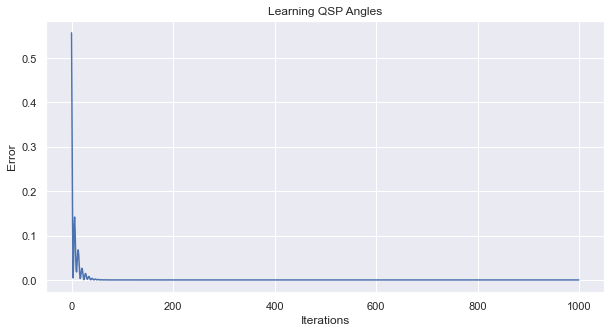

In [15]:
history = model.fit(
    x=theta_input,
    y=expected_real_px,
    epochs=1000,
    verbose=0)
plot_loss(history)

### Visualize the output of the model for $-1 \leq x \leq 1$


The trainable parameters of the model are the $\Phi$. We can see that the polynomial has the desired roots.

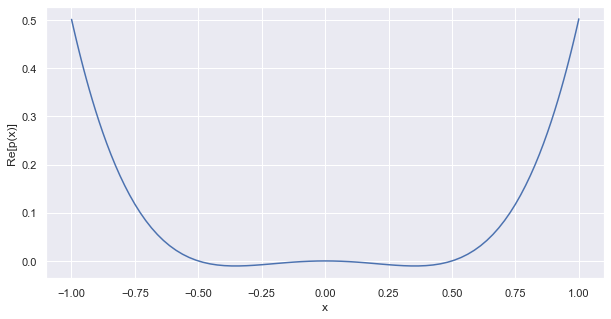

In [16]:
thetas_test = np.arange(0, np.pi, np.pi / 100)
model_real_px = model.predict(thetas_test)

# remember x = cos(theta)
df = pd.DataFrame({"x": np.cos(thetas_test), "Re[p(x)]": model_real_px})
sns.lineplot(x="x", y="Re[p(x)]", data=df)
plt.show()

### Construct QSP Circuit

We can construct the circuit parameterized by the learned $\Phi$ and visualize the circuit.

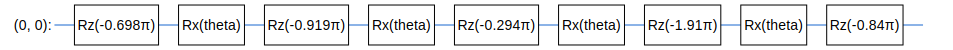

In [17]:
phis = model.trainable_weights[0].numpy()
qsp_circuit = QSPCircuit(phis)
qsp_circuit.svg()

### Check the Circuit

Let's check the $\Phi$ by plotting the real and imaginary parts of the upper left element ($p(x)$) in the unitary of the circuit for $-1 \leq x \leq 1$. We use the function `eval_px`.

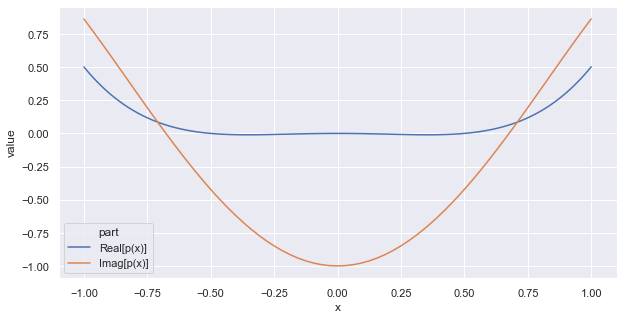

In [18]:
circuit_px = qsp_circuit.eval_px(thetas_test)

df = pd.DataFrame({"x": np.cos(thetas_test), "Real[p(x)]": np.real(circuit_px), "Imag[p(x)]": np.imag(circuit_px)})
df = df.melt("x", var_name="part", value_name="value")
sns.lineplot(x="x", y="value", hue="part", data=df)
plt.show()